In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# carregar dados
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# target (log-transformada para modelagem futura)
train['SalePrice_log'] = np.log1p(train['SalePrice'])

# exibir 5 primeiras linhas
train.head()

Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePrice_log
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.429220


# análise visual da correlação com o preço
quais variáveis numéricas têm mais relação com o preço da casa

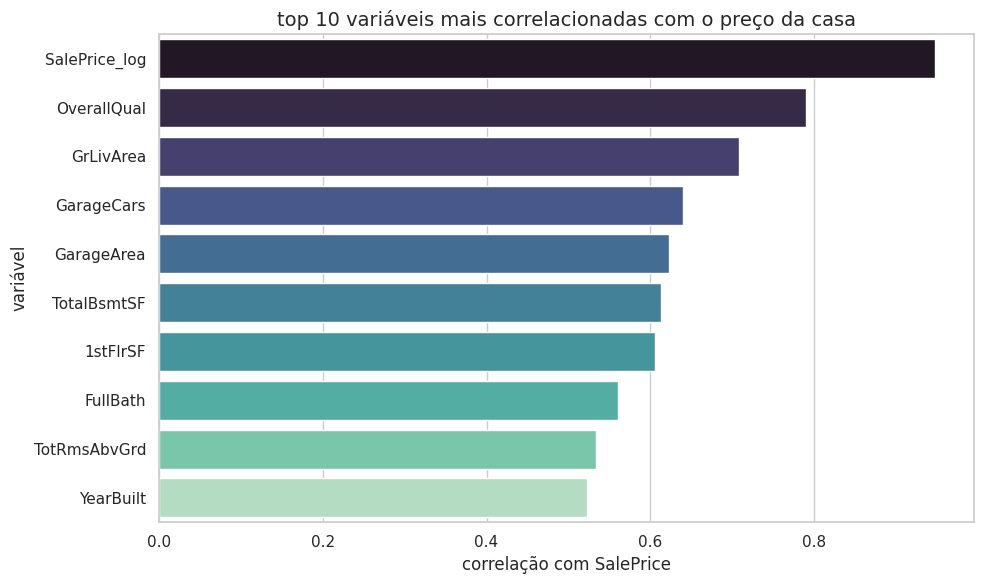

In [3]:
# correlação entre todas as variáveis numéricas
corr = train.corr(numeric_only=True)

# selecionar as 10 variáveis mais correlacionadas com o SalePrice
top_corr = corr['SalePrice'].sort_values(ascending=False)[1:11]

# plotagem
plt.figure(figsize=(10,6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='mako')
plt.title('top 10 variáveis mais correlacionadas com o preço da casa', fontsize=14)
plt.xlabel('correlação com SalePrice')
plt.ylabel('variável')
plt.tight_layout()
plt.show()



# preço médio por bairro
quais bairros têm os preços mais altos, usando a média de venda

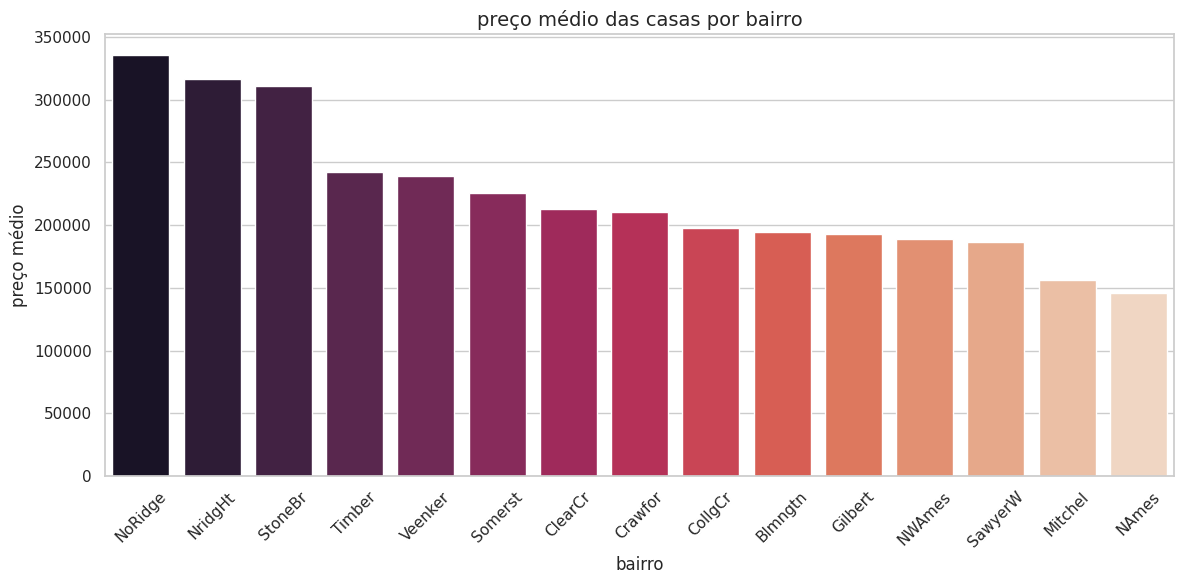

In [4]:
# agrupar por bairro e calcular preço médio
neigh_prices = train.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False)

# 15 principais
plt.figure(figsize=(12,6))
sns.barplot(x=neigh_prices.index[:15], y=neigh_prices.values[:15], palette='rocket')
plt.title('preço médio das casas por bairro', fontsize=14)
plt.ylabel('preço médio')
plt.xlabel('bairro')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# área vs preço (com destaque para qualidade da casa)
esse gráfico mostra se o tamanho da casa influencia no preço, e colore os pontos pela qualidade (OverallQual)

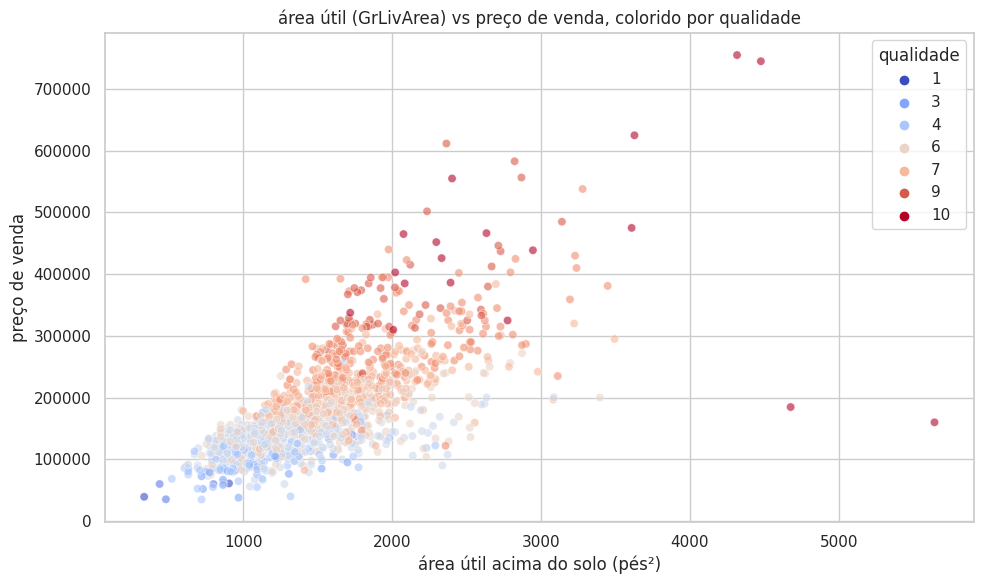

In [5]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=train,
    x='GrLivArea', y='SalePrice',
    hue='OverallQual',
    palette='coolwarm',
    alpha=0.6
)
plt.title('área útil (GrLivArea) vs preço de venda, colorido por qualidade')
plt.xlabel('área útil acima do solo (pés²)')
plt.ylabel('preço de venda')
plt.legend(title='qualidade')
plt.tight_layout()
plt.show()

# engenharia de variáveis
inclusão de novas colunas com novos significados, baseadas em combinações ou transformações das originais

In [6]:
# cópia do original
df = train.copy()

# TotalBathrooms: conta banheiros totais da casa (porão + acima do solo) (0.5)
df['TotalBathrooms'] = (df['FullBath'] + df['HalfBath'] * 0.5 +
                        df['BsmtFullBath'] + df['BsmtHalfBath'] * 0.5)

# HouseAge: idade da casa em anos - assumindo que estamos em 2025
df['HouseAge'] = 2025 - df['YearBuilt']

# IsRemodeled: valor binário se a casa foi reformada após ser construída
df['IsRemodeled'] = (df['YearBuilt'] != df['YearRemodAdd']).astype(int)

# TotalSF: soma do espaço utilizável total
df['TotalSF'] = df['TotalBsmtSF'] + df['GrLivArea']

# Qualidade composta: multiplicação de qualidade × condição
df['QualityScore'] = df['OverallQual'] * df['OverallCond']

# preço por pé quadrado
df['PricePerSF'] = df['SalePrice'] / df['GrLivArea']

# agrupamento de bairros em faixas de preço: luxo ou padrão
avg_prices_by_neigh = df.groupby('Neighborhood')['SalePrice'].mean()
df['NeighborhoodType'] = df['Neighborhood'].map(
    lambda x: 'Luxo' if avg_prices_by_neigh[x] > 300000 else 'Padrão'
)

# visualizar as novas colunas
df[['TotalBathrooms', 'HouseAge', 'IsRemodeled', 'TotalSF', 'QualityScore', 'PricePerSF', 'NeighborhoodType']].head()


,TotalBathrooms,HouseAge,IsRemodeled,TotalSF,QualityScore,PricePerSF,NeighborhoodType
0,3.5,22,0,2566,35,121.929825,Padrão
1,2.5,49,0,2524,48,143.819334,Padrão
2,3.5,24,1,2706,35,125.139978,Padrão
3,2.0,110,1,2473,35,81.537566,Padrão
4,3.5,25,0,3343,40,113.739763,Luxo


# visualização das novas features

## preço médio por tipo de bairro (luxo vs padrão)

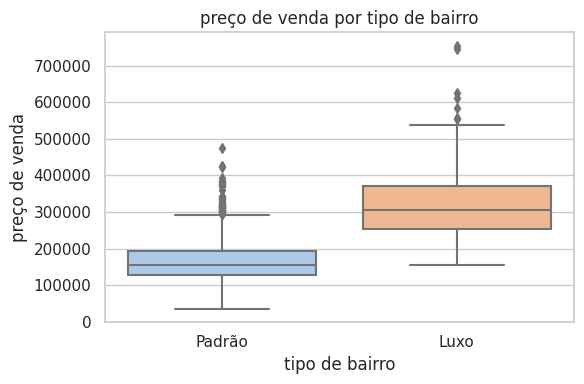

In [7]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='NeighborhoodType', y='SalePrice', palette='pastel')
plt.title('preço de venda por tipo de bairro')
plt.xlabel('tipo de bairro')
plt.ylabel('preço de venda')
plt.tight_layout()
plt.show()

# relação entre idade da casa e preço

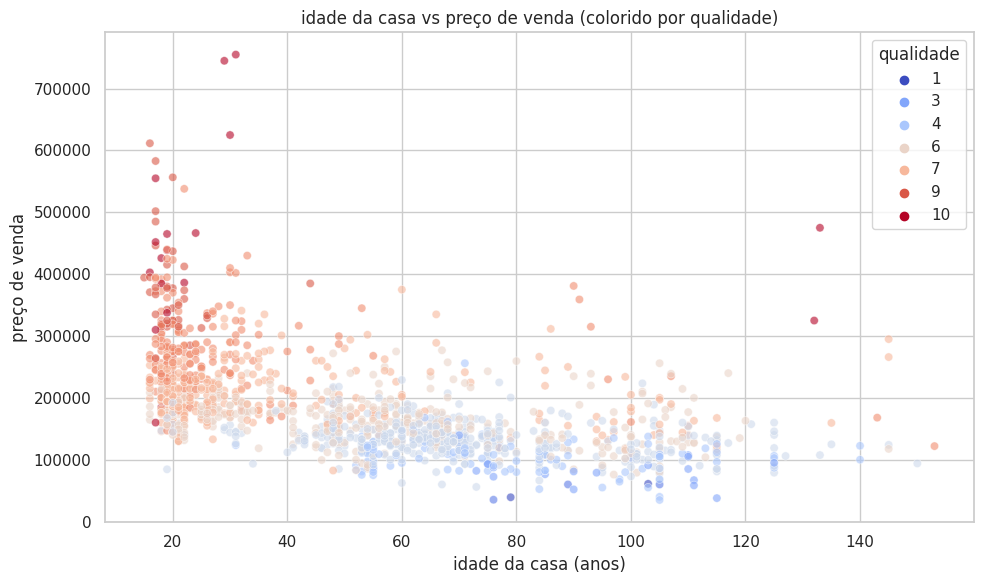

In [8]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='HouseAge', y='SalePrice', hue='OverallQual', palette='coolwarm', alpha=0.6)
plt.title('idade da casa vs preço de venda (colorido por qualidade)')
plt.xlabel('idade da casa (anos)')
plt.ylabel('preço de venda')
plt.legend(title='qualidade')
plt.tight_layout()
plt.show()

# número total de banheiros vs preço

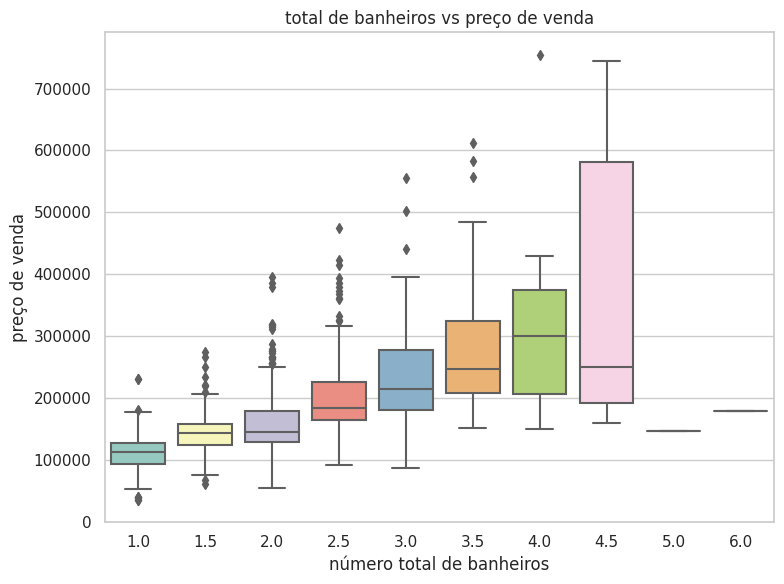

In [9]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='TotalBathrooms', y='SalePrice', palette='Set3')
plt.title('total de banheiros vs preço de venda')
plt.xlabel('número total de banheiros')
plt.ylabel('preço de venda')
plt.tight_layout()
plt.show()

# área total (TotalSF) vs preço

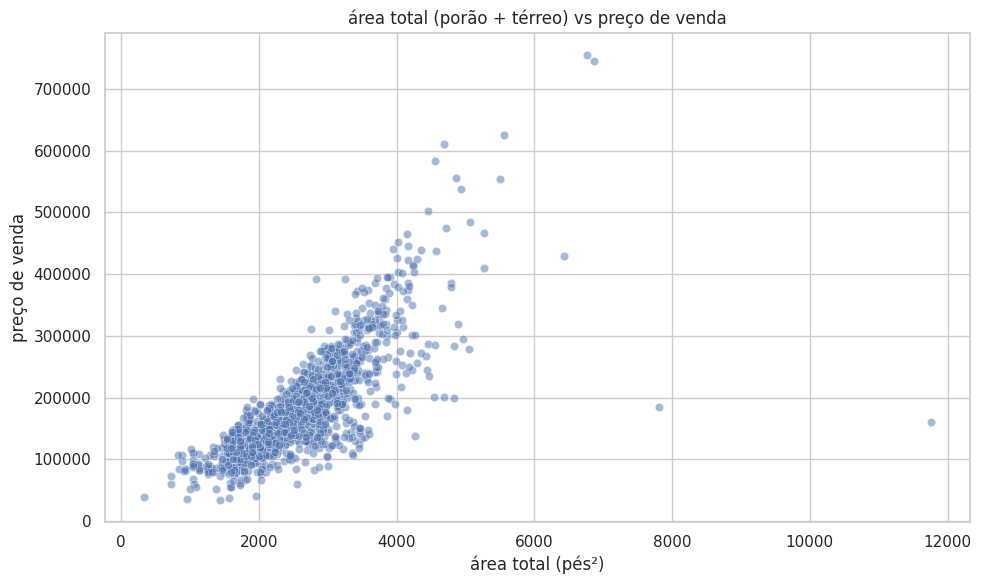

In [10]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='TotalSF', y='SalePrice', alpha=0.5)
plt.title('área total (porão + térreo) vs preço de venda')
plt.xlabel('área total (pés²)')
plt.ylabel('preço de venda')
plt.tight_layout()
plt.show()

# score de qualidade vs preço

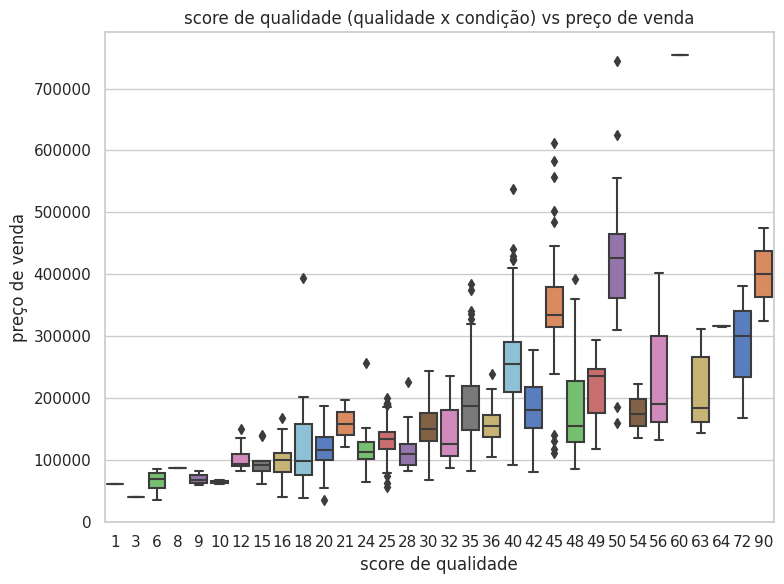

In [11]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='QualityScore', y='SalePrice', palette='muted')
plt.title('score de qualidade (qualidade x condição) vs preço de venda')
plt.xlabel('score de qualidade')
plt.ylabel('preço de venda')
plt.tight_layout()
plt.show()

# visualização sem outliers

In [12]:
# criar versão sem outliers
df_clean = df[(df['GrLivArea'] < 4500) & (df['SalePrice'] < 600000)]

# visualizar quantos dados foram removidos
print("original (com outliers):", df.shape)
print("limpo (sem outliers):", df_clean.shape)

original (com outliers): (1460, 89)
limpo (sem outliers): (1454, 89)


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

# selecionar features relevantes
features = ['GrLivArea', 'TotalBathrooms', 'TotalSF', 'HouseAge', 'IsRemodeled', 'QualityScore']

# treino/teste
X = df[features]
y = df['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# modelo
model1 = LinearRegression()
model1.fit(X_train, y_train)
pred1 = model1.predict(X_val)

# avaliação
rmsle1 = np.sqrt(mean_squared_log_error(y_val, pred1))
print("modelo 1 (com outliers) - RMSLE:", round(rmsle1, 4))


modelo 1 (com outliers) - RMSLE: 0.2064


In [14]:
# treino/teste
X_clean = df_clean[features]
y_clean = df_clean['SalePrice']
Xc_train, Xc_val, yc_train, yc_val = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# modelo
model2 = LinearRegression()
model2.fit(Xc_train, yc_train)
pred2 = model2.predict(Xc_val)

# evitar valores negativos
pred2 = np.maximum(pred2, 0)

# avaliação
rmsle2 = np.sqrt(mean_squared_log_error(yc_val, pred2))
print("modelo 2 (sem outliers) - RMSLE:", round(rmsle2, 4))

modelo 2 (sem outliers) - RMSLE: 0.6584


# distribuição do preço (SalePrice)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


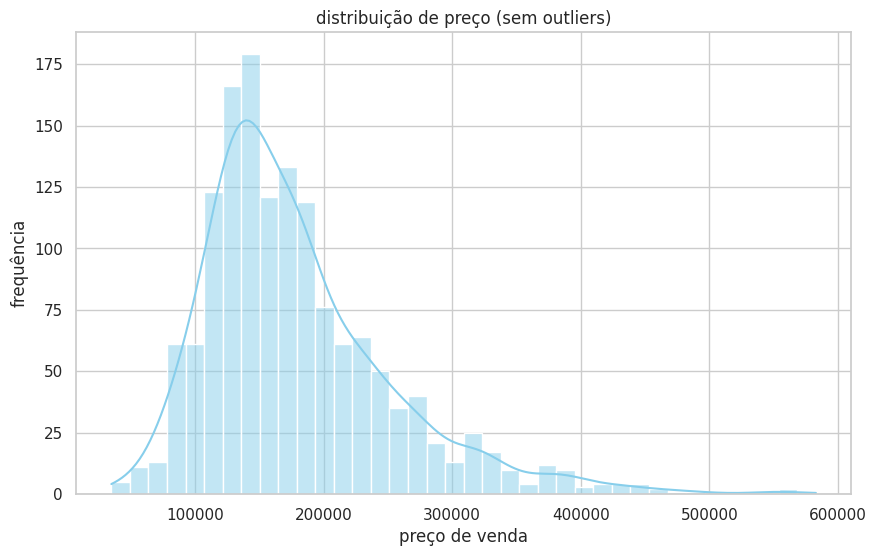

In [15]:
plt.figure(figsize=(10,6))
sns.histplot(df_clean['SalePrice'], kde=True, color='skyblue')
plt.title('distribuição de preço (sem outliers)')
plt.xlabel('preço de venda')
plt.ylabel('frequência')
plt.show()

# preço vs. área construída (GrLivArea)

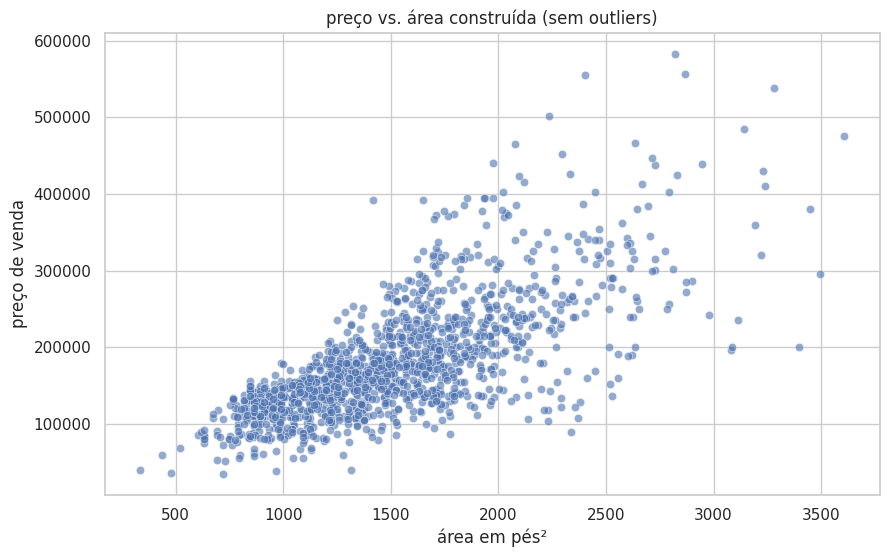

In [16]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df_clean, alpha=0.6)
plt.title('preço vs. área construída (sem outliers)')
plt.xlabel('área em pés²')
plt.ylabel('preço de venda')
plt.show()

# preço vs. total de banheiros (TotalBathrooms)

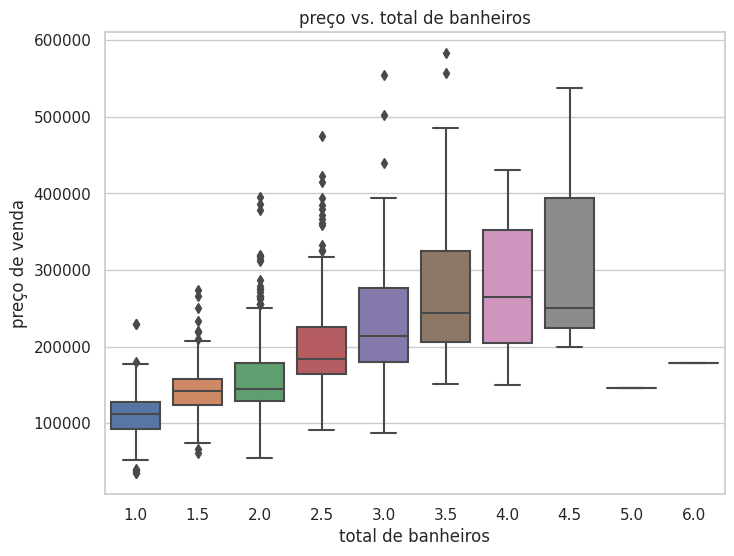

In [17]:
plt.figure(figsize=(8,6))
sns.boxplot(x='TotalBathrooms', y='SalePrice', data=df_clean)
plt.title('preço vs. total de banheiros')
plt.xlabel('total de banheiros')
plt.ylabel('preço de venda')
plt.show()

# preço vs. idade da casa (HouseAge)

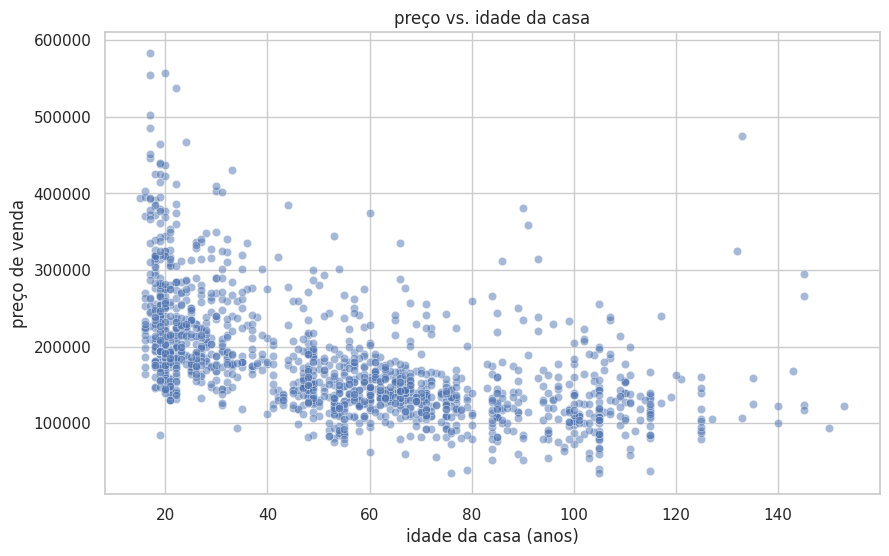

In [18]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='HouseAge', y='SalePrice', data=df_clean, alpha=0.5)
plt.title('preço vs. idade da casa')
plt.xlabel('idade da casa (anos)')
plt.ylabel('preço de venda')
plt.show()

# preço por qualidade (OverallQual)

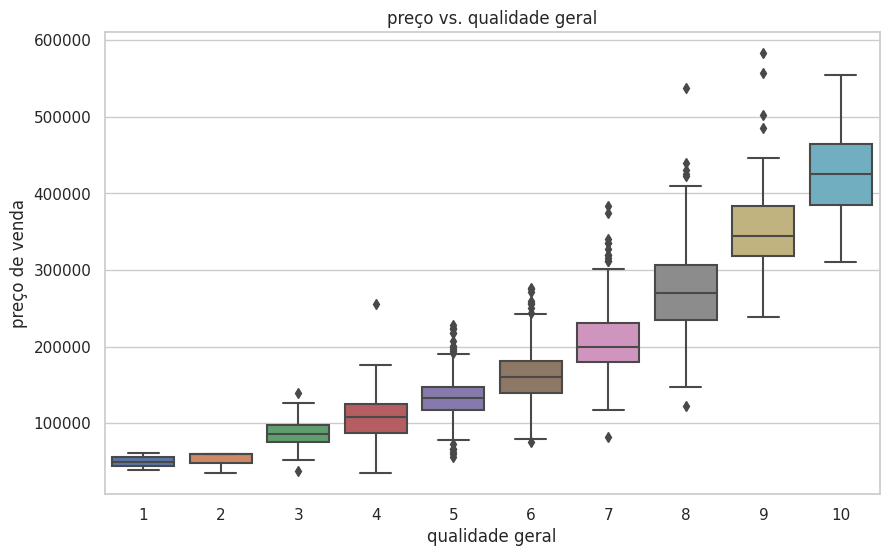

In [19]:
plt.figure(figsize=(10,6))
sns.boxplot(x='OverallQual', y='SalePrice', data=df_clean)
plt.title('preço vs. qualidade geral')
plt.xlabel('qualidade geral')
plt.ylabel('preço de venda')
plt.show()

# preço por condição (OverallCond)

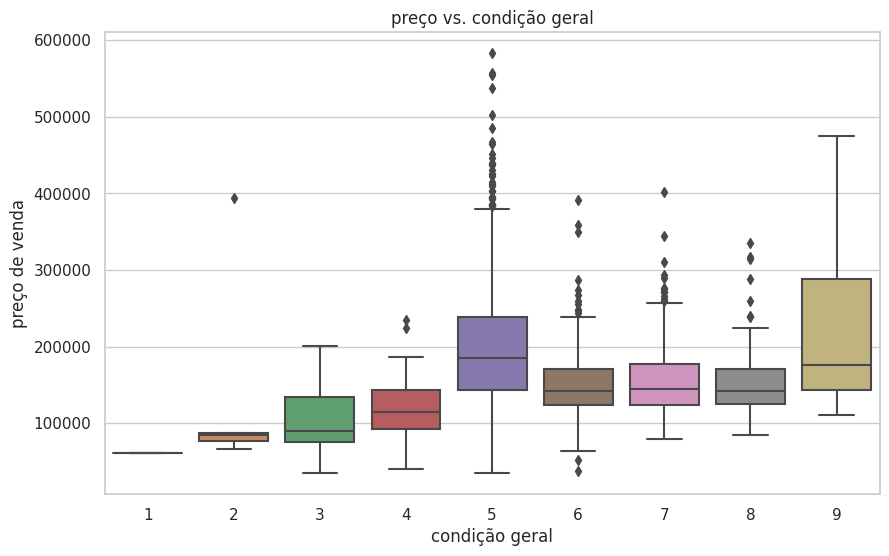

In [20]:
plt.figure(figsize=(10,6))
sns.boxplot(x='OverallCond', y='SalePrice', data=df_clean)
plt.title('preço vs. condição geral')
plt.xlabel('condição geral')
plt.ylabel('preço de venda')
plt.show()

# preço vs. remodelação (IsRemodeled)

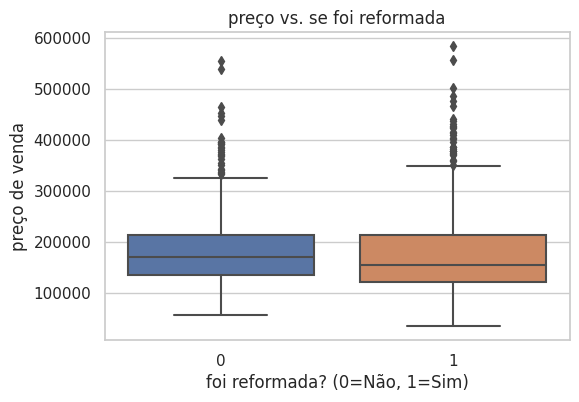

In [21]:
plt.figure(figsize=(6,4))
sns.boxplot(x='IsRemodeled', y='SalePrice', data=df_clean)
plt.title('preço vs. se foi reformada')
plt.xlabel('foi reformada? (0=Não, 1=Sim)')
plt.ylabel('preço de venda')
plt.show()

# mapa de calor de correlação

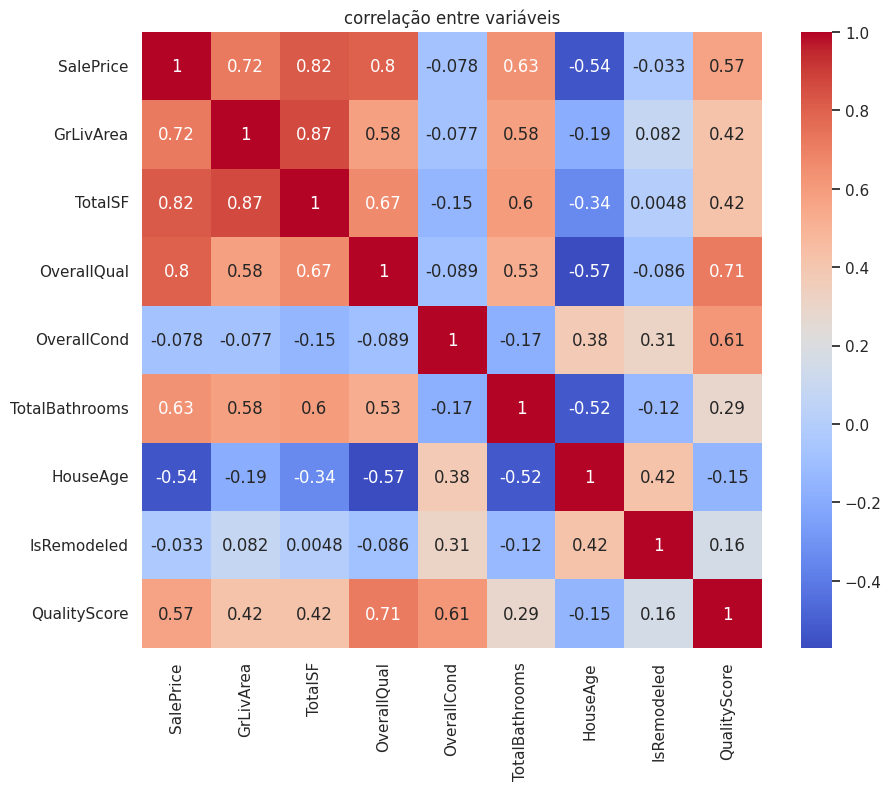

In [22]:
plt.figure(figsize=(10,8))
corr = df_clean[['SalePrice', 'GrLivArea', 'TotalSF', 'OverallQual', 'OverallCond', 'TotalBathrooms', 'HouseAge', 'IsRemodeled', 'QualityScore']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('correlação entre variáveis')
plt.show()

# visualizações com variáveis categóricas (sem outliers)

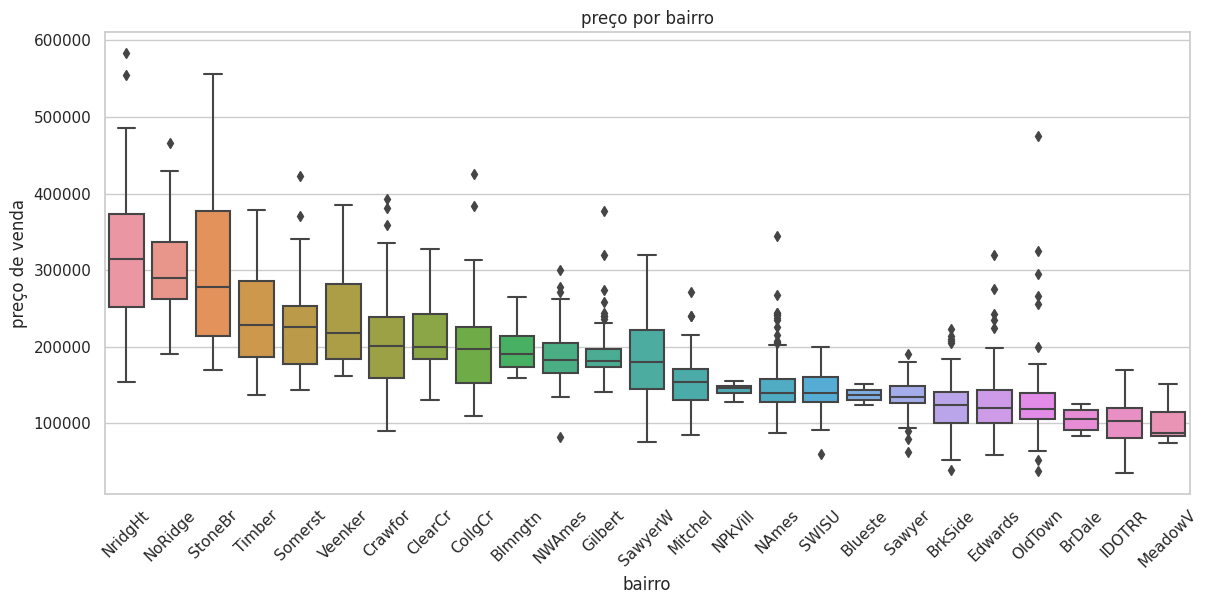

In [23]:
plt.figure(figsize=(14,6))
order = df_clean.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=False).index
sns.boxplot(x='Neighborhood', y='SalePrice', data=df_clean, order=order)
plt.xticks(rotation=45)
plt.title('preço por bairro')
plt.xlabel('bairro')
plt.ylabel('preço de venda')
plt.show()

bairros como NridgHt e StoneBr têm preços mais altos

# preço por tipo de venda (SaleCondition)

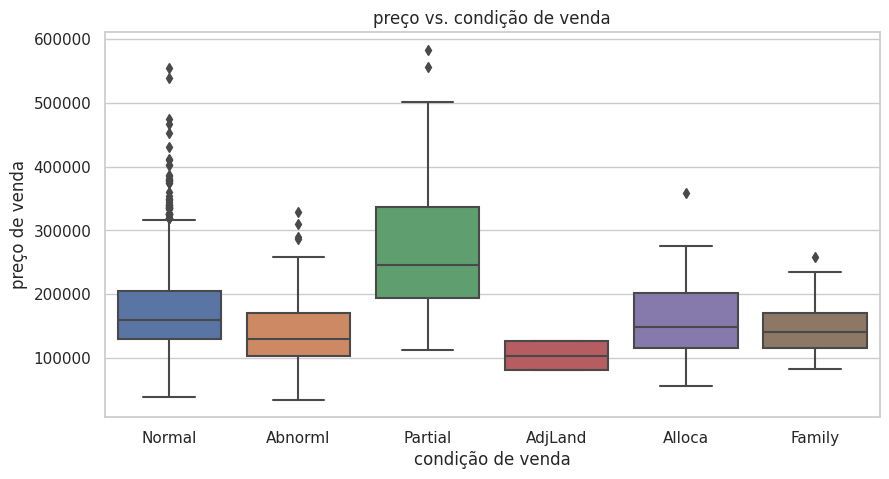

In [24]:
plt.figure(figsize=(10,5))
sns.boxplot(x='SaleCondition', y='SalePrice', data=df_clean)
plt.title('preço vs. condição de venda')
plt.xlabel('condição de venda')
plt.ylabel('preço de venda')
plt.show()

vendas normais costumam ter preços maiores

# preço por qualidade externa (ExterQual)

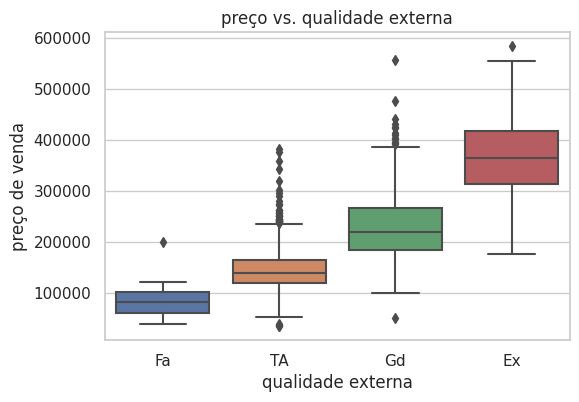

In [25]:
plt.figure(figsize=(6,4))
sns.boxplot(x='ExterQual', y='SalePrice', data=df_clean, order=['Fa', 'TA', 'Gd', 'Ex'])
plt.title('preço vs. qualidade externa')
plt.xlabel('qualidade externa')
plt.ylabel('preço de venda')
plt.show()

# preço por tipo de aquecimento (HeatingQC)

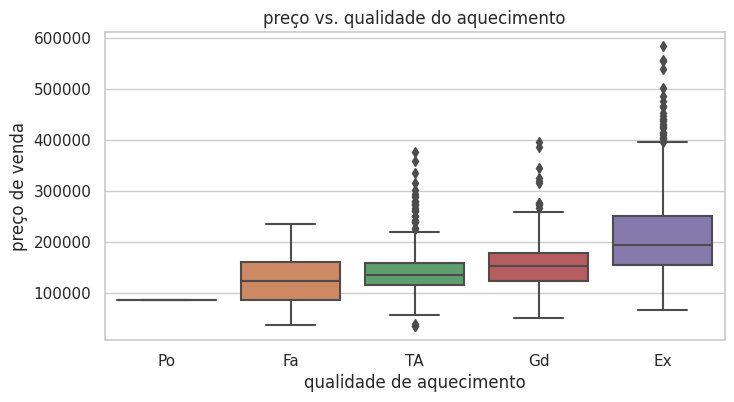

In [26]:
plt.figure(figsize=(8,4))
sns.boxplot(x='HeatingQC', y='SalePrice', data=df_clean, order=['Po', 'Fa', 'TA', 'Gd', 'Ex'])
plt.title('preço vs. qualidade do aquecimento')
plt.xlabel('qualidade de aquecimento')
plt.ylabel('preço de venda')
plt.show()

Poor | Fair | Typical/Average | Good | Excellent

# engenharia de features

1. transformar variáveis categóricas ordinais em números

2. criar dummies para variáveis nominais

3. selecionar colunas para o modelo



# mapear variáveis ordinais (qualidade)

In [27]:
qualidade_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

df_clean.loc[:, 'ExterQual_num'] = df_clean['ExterQual'].map(qualidade_map)
df_clean.loc[:, 'HeatingQC_num'] = df_clean['HeatingQC'].map(qualidade_map)

/tmp/ipykernel_13/3571204085.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, 'ExterQual_num'] = df_clean['ExterQual'].map(qualidade_map)
/tmp/ipykernel_13/3571204085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, 'HeatingQC_num'] = df_clean['HeatingQC'].map(qualidade_map)


# criar dummies para variáveis nominais (sem ordem)

In [28]:
df_dummies = pd.get_dummies(df_clean[['Neighborhood', 'SaleCondition']], drop_first=True)

# juntar tudo em um df final para modelagem

In [29]:
# variáveis numéricas e criadas
model_df = df_clean[[
    'SalePrice', 'GrLivArea', 'OverallQual', 'OverallCond',
    'TotalBathrooms', 'HouseAge', 'IsRemodeled', 'ExterQual_num', 'HeatingQC_num'
]].join(df_dummies)

# verificar df final

In [30]:
model_df.head()

,SalePrice,GrLivArea,OverallQual,OverallCond,TotalBathrooms,HouseAge,IsRemodeled,ExterQual_num,HeatingQC_num,Neighborhood_Blueste,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,208500,1710,7,5,3.5,22,0,4,5,False,...,False,False,False,False,False,False,False,False,True,False
1,181500,1262,6,8,2.5,49,0,3,5,False,...,False,False,False,False,True,False,False,False,True,False
2,223500,1786,7,5,3.5,24,1,4,5,False,...,False,False,False,False,False,False,False,False,True,False
3,140000,1717,7,5,2.0,110,1,3,4,False,...,False,False,False,False,False,False,False,False,False,False
4,250000,2198,8,5,3.5,25,0,4,5,False,...,False,False,False,False,False,False,False,False,True,False


# modelos de regressão

# separar X e y

In [31]:
# features e alvo
X = model_df.drop('SalePrice', axis=1)
y = model_df['SalePrice']

# treinamento e validação
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# treino modelo simples: linear regression

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
import numpy as np

# treinar modelo
lr = LinearRegression()
lr.fit(X_train, y_train)

# prever
preds = lr.predict(X_val)

# corrigir valores negativos (não faz sentido ter preço negativo)
preds = np.where(preds < 0, 0, preds)

# calcular RMSLE
rmsle = np.sqrt(mean_squared_log_error(y_val, preds))
print("RMSLE (Linear Regression):", round(rmsle, 4))

RMSLE (Linear Regression): 0.6435


# preparar dados do test.csv

In [33]:
# carregar dados de teste
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# engenharia de features no test.csv
test['ExterQual_num'] = test['ExterQual'].map(qualidade_map)
test['HeatingQC_num'] = test['HeatingQC'].map(qualidade_map)

# dummies (usando as mesmas variáveis utilizadas em treino)
test_dummies = pd.get_dummies(test[['Neighborhood', 'SaleCondition']], drop_first=True)

# corrigir colunas faltantes
for col in df_dummies.columns:
    if col not in test_dummies.columns:
        test_dummies[col] = 0
test_dummies = test_dummies[df_dummies.columns]  # garantir mesma ordem

# juntar todas as features no test
test['TotalBathrooms'] = test['FullBath'] + (0.5 * test['HalfBath']) + test['BsmtFullBath'].fillna(0) + (0.5 * test['BsmtHalfBath'].fillna(0))
test['HouseAge'] = test['YrSold'] - test['YearBuilt']
test['IsRemodeled'] = (test['YearRemodAdd'] != test['YearBuilt']).astype(int)

X_test = test[[
    'GrLivArea', 'OverallQual', 'OverallCond', 'TotalBathrooms', 'HouseAge',
    'IsRemodeled', 'ExterQual_num', 'HeatingQC_num'
]].join(test_dummies)

# gerar previsões e criar submissão

In [34]:
# previsões
test_preds = lr.predict(X_test)

# criar CSV
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': test_preds
})
submission.to_csv('/kaggle/working/submission.csv', index=False)